In [12]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from peft import PeftModel, PeftConfig
from dotenv import dotenv_values
import torch
from tqdm.auto import tqdm
import evaluate

from utils import DataPreprocessor, DatasetFormatConverter
from utils import DataPreprocessor

from src.billm import LlamaForTokenClassification

WANDB_KEY = dotenv_values(".env.base")['WANDB_KEY']
LLAMA_TOKEN = dotenv_values(".env.base")['LLAMA_TOKEN']
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']

adapters = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002"
peft_config = PeftConfig.from_pretrained(adapters)
BASE_MODEL_CHECKPOINT = peft_config.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT,token =HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
# seqeval = evaluate.load("seqeval")
DATASET_CHEKPOINT="ferrazzipietro/e3c-sentences" 
TRAIN_LAYER="en.layer1"
preprocessor = DataPreprocessor(BASE_MODEL_CHECKPOINT, 
                                tokenizer)
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter = DatasetFormatConverter(dataset)
dataset_format_converter.apply()
ds = dataset_format_converter.dataset
label2id = dataset_format_converter.label2id
id2label = dataset_format_converter.get_id2label()
label_list = dataset_format_converter.get_label_list()
dataset_format_converter.set_tokenizer(tokenizer)
dataset_format_converter.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
train_data, val_data, test_data = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)


In [14]:
train_data

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 669
})

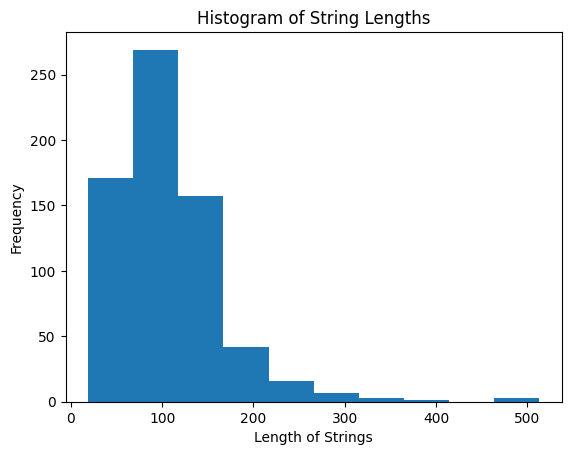

In [3]:
import matplotlib.pyplot as plt

# Get the lengths of the strings
lengths = [len(sentence) for sentence in train_data['sentence']]

# Plot the histogram
plt.hist(lengths, bins=10)
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.show()

In [15]:
bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                )

model = LlamaForTokenClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(label2id), id2label=id2label, label2id=label2id,
    token = HF_TOKEN,
    cache_dir='/data/disk1/share/pferrazzi/.cache',
    device_map='auto',
    quantization_config = bnb_config)
model = PeftModel.from_pretrained(model, adapters, token = HF_TOKEN)
model = model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
Some weights of LlamaForTokenClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.
/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [16]:

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [5]:
examples = [train_data['sentence'][0] , train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)

In [ ]:
gen = OutputGeneration(model, tokenizer, id2label)
pl = gen._create_prediction_list(generated_ids)

In [6]:
for i, s in enumerate([0,5]):
    print((train_data[s]['sentence']))
    print(f"n words in sentence: {len(train_data[s]['sentence'].split())}")
    print(f"len_ sentence: {len(train_data[s]['sentence'])}")
    print(f"n tokens with labels: {len(train_data[s]['labels'])}")
    print(f"n  created labels: {len(generated_ids['logits'][i])}")

Their child acquired walking at the age of 14 months.
n words in sentence: 10
len_ sentence: 53
n tokens with labels: 14
n  created labels: 78
Pertinent laboratory studies included a hemoglobin level of 10 g/dL, platelet count was normal, blood urea of 1,2 g/l (0,18-0,45 g/L), and a creatinine level of 68 mg/L (7-13 mg/L).
n words in sentence: 30
len_ sentence: 181
n tokens with labels: 78
n  created labels: 78


In [25]:
import pandas as pd


token_classifier = pipeline("token-classification", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)
token_classifier(train_data[0]['sentence'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenCl

RuntimeError: The expanded size of the tensor (14) must match the existing size (4096) at non-singleton dimension 2.  Target sizes: [1, 32, 14, 14].  Tensor sizes: [1, 1, 4096, 14]

In [20]:
print(train_data[0]['tokens'])
example = train_data[0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['Their', 'child', 'acquired', 'walking', 'at', 'the', 'age', 'of', '14', 'months.']


['<s>',
 '▁Their',
 '▁child',
 '▁acquired',
 '▁walking',
 '▁at',
 '▁the',
 '▁age',
 '▁of',
 '▁',
 '1',
 '4',
 '▁months',
 '.']

In [32]:
import pandas as pd


token_classifier = pipeline("ner", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)


#token_classifier(train_data[0]['tokens'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenClassification', 'L

[{'end': 24,
  'entity_group': 'B',
  'score': 0.657,
  'start': 7,
  'word': 'assessment found'},
 {'end': 38,
  'entity_group': 'B',
  'score': 0.794,
  'start': 32,
  'word': 'score'},
 {'end': 44,
  'entity_group': 'B',
  'score': 0.6616,
  'start': 40,
  'word': 'GCS)'},
 {'end': 48, 'entity_group': 'B', 'score': 0.6094, 'start': 47, 'word': ''},
 {'end': 52, 'entity_group': 'I', 'score': 0.585, 'start': 51, 'word': '1'},
 {'end': 53, 'entity_group': 'B', 'score': 0.572, 'start': 52, 'word': '5'},
 {'end': 66,
  'entity_group': 'B',
  'score': 0.824,
  'start': 55,
  'word': 'eye opening'},
 {'end': 70, 'entity_group': 'B', 'score': 0.708, 'start': 69, 'word': ''},
 {'end': 72, 'entity_group': 'B', 'score': 0.4004, 'start': 71, 'word': ','},
 {'end': 88,
  'entity_group': 'B',
  'score': 0.628,
  'start': 76,
  'word': 'bal response'},
 {'end': 93, 'entity_group': 'B', 'score': 0.6816, 'start': 91, 'word': '2'},
 {'end': 100,
  'entity_group': 'I',
  'score': 0.623,
  'start': 94,

In [18]:
import pandas as pd
import ast
import evaluate
seqeval = evaluate.load("seqeval")
data = load_dataset("csv", data_files="data/evaluation/train_data_LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_16_32_0.01_2_0.0002.csv")
def helper(example):
    example['model_output'] = ast.literal_eval(example['model_output'].replace('\n', ','))
    return example
data = data.map(lambda x: helper(x))



In [30]:
id2label


{0: 'O', 1: 'B', 2: 'I'}

In [54]:

def compute_metrics(logits, labels):
    model_output_logits = logits.cpu().detach().float().numpy()    
    predictions = np.argmax(model_output_logits, axis=1)
    print(predictions)
    print(len(predictions))
    print(len(labels))
    #labels = [labels*attn_mask for labels, attn_mask in zip(labels, attention_mask[:len(labels)])]
    # predicted_labels = []
    # for i in range(len(labels)):
    #     print('pred: ', predictions[i], 'label: ', labels[i])
    #     if labels[i] != -100:
    #      predicted_labels.append(id2label[predictions[i]])
    # print('labels predictions: ', predicted_labels)

    predicted_labels = [id2label[prediction] for i, prediction in enumerate(predictions[:len(labels)]) if labels[i] != -100 ]
    labels = [id2label[label] for label in labels if label != -100]
    print('labels: ', labels)
    print('predictions: ', predicted_labels)

    results = seqeval.compute(predictions=predicted_labels, references=labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["soverall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [46]:
print(train_data[0]['sentence'])
print(tokenizer(train_data[0]['sentence']))
encodeds

Their child acquired walking at the age of 14 months.
{'input_ids': [1, 11275, 2278, 16692, 22049, 472, 278, 5046, 310, 29871, 29896, 29946, 7378, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


{'input_ids': tensor([[    1, 11275,  2278, 16692, 22049,   472,   278,  5046,   310, 29871,
         29896, 29946,  7378, 29889,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2],
        [    1,   349,   814,  8946, 10212,  7606, 11898,  5134,   263,  9736,
           468,   417,  2109,  3233,   310, 29871, 29896, 29900,   330, 29914,
         29881, 29931, 29892, 15284,  1026,  2302,   471,  4226, 29892, 10416,
           318,  5638,   310, 29871, 29896, 29892, 29906,   330, 29914, 29880,
           313, 29900, 29892, 29896, 29947, 29899, 

In [55]:
examples = [train_data['sentence'][15], train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
compute_metrics(generated_ids['logits'][0],   train_data[0]['labels'])

[1 1 2 2 2 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
78
14
labels:  ['B', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
predictions:  ['B', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O']


ValueError: Got a string but expected a list instead: 'B'

In [63]:
seqeval.compute(predictions=[['A'], ['A'], ['B'], ['0']], references=[['A'], ['O'], ['B'], ['A']])

/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'_': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 0.5}